<a href="https://colab.research.google.com/github/shreyabansal25/TimeSeries-Forecasting/blob/master/ForeCastingLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Loading and Plotting Data

In [0]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("IncidentsData.csv", 
                      usecols = [1], 
                    )

In [167]:
data.head()

,Incidents
0,17.0
1,95.0
2,95.0
3,93.0
4,101.0


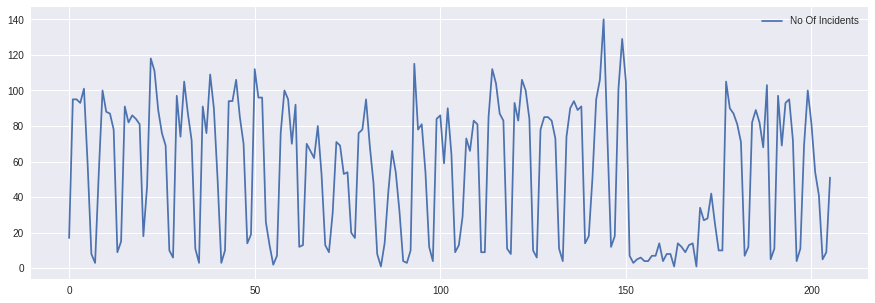

In [168]:
# Create a time series plot.
plt.figure(figsize = (15, 5))
plt.plot(data, label = "No Of Incidents")
plt.legend()
plt.show()

#Building Model

In [0]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

In [178]:
# Get the raw data values from the pandas data frame.
data_raw = data.values.astype("float32")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

# Print a few values.
dataset[0:5]

array([[0.11510792],
       [0.67625904],
       [0.67625904],
       [0.66187054],
       [0.7194245 ]], dtype=float32)

In [251]:
# Using 80% of data for training, 20% for validation.
TRAIN_SIZE = 0.80

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (164, 42)


In [0]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size -1):
        a = dataset[i:i+ window_size, 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size , 0])
    return(np.array(data_X), np.array(data_Y))

In [253]:
# Create test and training sets for one-step-ahead regression.
window_size = 7
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)



Original training data shape:
(156, 7)


In [254]:
# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

New training data shape:
(156, 1, 7)


Build simple LSTM model on training data
The LSTM architecture here consists of:
1.   One input layer.
2.   One LSTM layer of 4 blocks.
3.   One Dense layer to produce a single output.
4.   Use MSE as loss function.





In [255]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(4, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 50, 
              batch_size = 1, 
              verbose = 2)
    
    return(model)

# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

Epoch 1/50
 - 5s - loss: 0.1572
Epoch 2/50
 - 0s - loss: 0.0541
Epoch 3/50
 - 0s - loss: 0.0452
Epoch 4/50
 - 0s - loss: 0.0411
Epoch 5/50
 - 0s - loss: 0.0387
Epoch 6/50
 - 0s - loss: 0.0364
Epoch 7/50
 - 0s - loss: 0.0349
Epoch 8/50
 - 0s - loss: 0.0342
Epoch 9/50
 - 0s - loss: 0.0333
Epoch 10/50
 - 0s - loss: 0.0326
Epoch 11/50
 - 0s - loss: 0.0321
Epoch 12/50
 - 0s - loss: 0.0320
Epoch 13/50
 - 0s - loss: 0.0315
Epoch 14/50
 - 0s - loss: 0.0309
Epoch 15/50
 - 0s - loss: 0.0308
Epoch 16/50
 - 0s - loss: 0.0303
Epoch 17/50
 - 0s - loss: 0.0301
Epoch 18/50
 - 0s - loss: 0.0298
Epoch 19/50
 - 0s - loss: 0.0293
Epoch 20/50
 - 0s - loss: 0.0295
Epoch 21/50
 - 0s - loss: 0.0289
Epoch 22/50
 - 0s - loss: 0.0291
Epoch 23/50
 - 0s - loss: 0.0284
Epoch 24/50
 - 0s - loss: 0.0289
Epoch 25/50
 - 0s - loss: 0.0276
Epoch 26/50
 - 0s - loss: 0.0287
Epoch 27/50
 - 0s - loss: 0.0284
Epoch 28/50
 - 0s - loss: 0.0283
Epoch 29/50
 - 0s - loss: 0.0282
Epoch 30/50
 - 0s - loss: 0.0281
Epoch 31/50
 - 0s -

#Predictions and model evaluation

In [259]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred, orig_data[0])
  

rmse_train, train_predict,train_original = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict, test_original = predict_and_score(model1, test_X, test_Y)
print("Test data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Test data score: 22.18 RMSE
Test data score: 22.00 RMSE


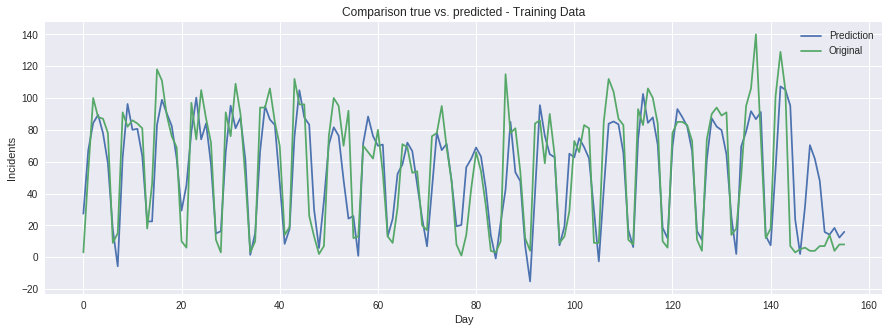

In [262]:
# Create the plot for TEST
plt.figure(figsize = (15, 5))
#plt.plot(data, label = "True value")
#plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(train_predict, label = "Prediction")
plt.plot(train_original, label = "Original")
plt.xlabel("Day")
plt.ylabel("Incidents")
plt.title("Comparison true vs. predicted - Training Data")
plt.legend()
plt.show()

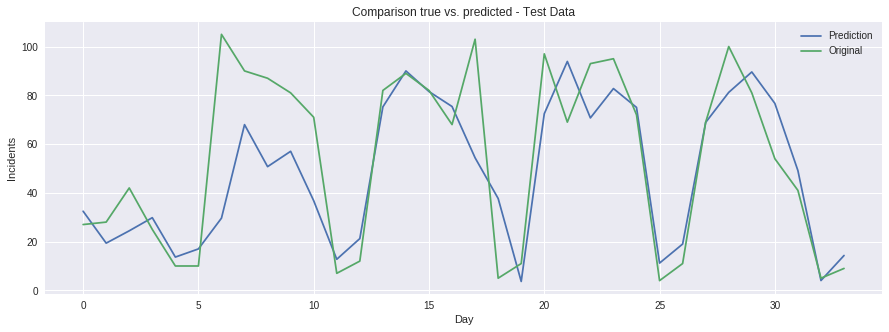

In [263]:
# Create the plot for TEST
plt.figure(figsize = (15, 5))
#plt.plot(data, label = "True value")
#plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict, label = "Prediction")
plt.plot(test_original, label = "Original")
plt.xlabel("Day")
plt.ylabel("Incidents")
plt.title("Comparison true vs. predicted - Test Data")
plt.legend()
plt.show()